In [2]:
%load_ext autoreload
%autoreload 2

TODO: 
    stain normaliztion
    augmantation
    

In [3]:
import os
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Concatenate 
# Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization

from keras.applications.vgg19 import VGG19

%matplotlib inline

Using TensorFlow backend.


In [4]:
from utils.preprocess import DataGenerator
from utils.callbacks import PlotCurves
from utils.load_data import load_data
from utils.comparams import auc

In [5]:
from utils.comparams import calculate_auc, auc

### Data Generator

In [6]:
data_dir = './data/'

In [7]:
x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', limit=10000, val_limit=10000)
len(x_train), len(x_valid)

(10000, 10000)

In [8]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

In [9]:
del train_id
del val_id
del data_dir

## MODEL

In [10]:
def build_arch_2_net():
    
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
    x = vgg19.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities
    model = Model(inputs=vgg19.input, outputs=y)
    
    # Train only the top layer
    for layer in vgg19.layers:
        layer.trainable = False

    return model

def build_arch_4_net():
    
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
    x = vgg19.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities
    model = Model(inputs=vgg19.input, outputs=y)
    
    # Train only the top layer
    for layer in vgg19.layers:
        layer.trainable = False

    return model

def build_arch_5_net():
    
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
    x = vgg19.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    y = Dense(2, activation='softmax')(x)
    model = Model(inputs=vgg19.input, outputs=y)
    
    # Train only the top layer
    for layer in vgg19.layers:
        layer.trainable = False

    return model

def build_arch_6_net():
    
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
    x = vgg19.output
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    out = Concatenate(axis=-1)([out1, out2, out3])
    out = Dropout(0.5)(out)
    y = Dense(2, activation='softmax')(out) # sigmoid instead of softmax to have independent probabilities

    model = Model(inputs=vgg19.input, outputs=y)
    
    # Train only the top layer
    for layer in vgg19.layers:
        layer.trainable = False

    return model


def build_arch_8_net():
    
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
    x = vgg19.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    y = Dense(2, activation='softmax')(x)
    model = Model(inputs=vgg19.input, outputs=y)
    
    # Train only the top layer
    for layer in vgg19.layers:
        layer.trainable = False

    return model

In [11]:
model = build_arch_8_net()

Instructions for updating:
Colocations handled automatically by placer.


### Compile

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000005)

In [13]:
optimizer = Adam(lr=0.001)#, beta_1=0.9, beta_2=0.999)
# 0.002 0.02 2e-5 0.001
# optimizer=Adam(lr=0.0002, decay=0.00001),
#               loss='binary_crossentropy',
#               metrics=['accuracy']
loss = 'binary_crossentropy'
# 'categorical_crossentropy'
metrics = ['acc', auc]

In [14]:
model.compile(optimizer, loss, metrics)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


## Train the model

In [ ]:
# directory to save the best model
file_dir = './Model'
if not os.path.exists(file_dir):
    os.mkdir(file_dir)
    
model_name = 'vgg19_model_bin_cross_arch_8_lr_0_0001'
    
network_filepath = os.path.join(file_dir, model_name + '.h5')

In [ ]:
# Define batch size.
batch_size = 128
n_epoch = 10
# time_limit = 500 # time limit in minute (500 -> 8 hrs and 20 min)

# Parameters for generators
params = {
    'dim': (224, 224),
    'batch_size': batch_size,
    'n_classes': 2,
    'shuffle': True
}

# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **params)
validation_generator = DataGenerator(partition['validation'], x_valid, val_labels, **params)

# #a function to save last_model compatible with the on_interrupt handler of TimerCallback
# def saveWeights(model, elapsed):
#     model.save_weights(os.path.join(file_dir, model_name + '_weights.h5'))


# Callbacks,
callbacks = [PlotCurves(model_name=model_name), learning_rate_reduction]#, TimerCallback(1, on_interrupt=saveWeights)]
#roc_callback(training_data=training_generator,validation_data=validation_generator)

In [ ]:
del x_train
del x_valid
del y_train
del y_valid
del train_labels
del val_labels

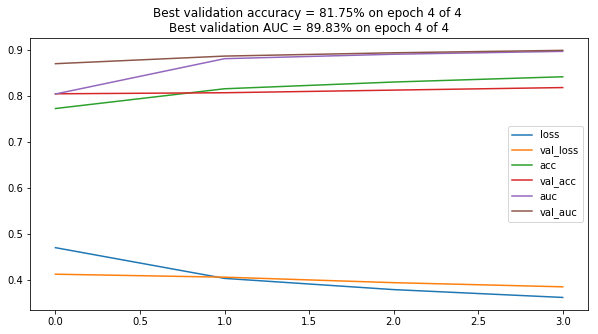

Epoch 5/10
32/78 [===========>..................] - ETA: 7:16 - loss: 0.3425 - acc: 0.8491 - auc: 0.8998

In [ ]:
# Training with learning 
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)

In [ ]:
model.save(network_filepath)

### Runs

# Calculate AUC

In [32]:
data_dir = './data'
# data_dir = './data'

x_test, y_test_true = load_data(data_dir, purpose='test')#, norm='macenko')

# indexes
test_id = np.arange(len(x_test))

# create a useful dictionary structures
partition = {}
partition['test'] = test_id
    
test_labels = {str(i) : y_test_true[i].flatten()[0] for i in test_id}

len(test_labels)

32768

In [33]:
# Define batch size.
batch_size = 128

# Parameters for generators
params = {
    'dim': (224, 224),
    'batch_size': batch_size,
    'n_classes': 2,
    'shuffle': False
}

# Generators
test_generator = DataGenerator(partition['test'], x_test, test_labels, **params)

preds = model.predict_generator(test_generator)

In [34]:
true_labels = np.array(y_test_true).flatten()

pred_labels = np.array([p[1] for p in preds])

calculate_auc(true_labels, pred_labels)

sklearn auc: 0.8980602044796571
tf auc: [0.89805764, 0.89805764]
